# Uplift Random Forest

In [131]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py/")

In [132]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

In [235]:
# Data generation
df, feature_cols = make_uplift_classification(n_samples=1000, 
                                              treatment_name=["control", "treatment"],
                                              n_classification_features=10,
                                              n_classification_informative=10)

# Rename features for easy interpretation of visualization
feature_cols_new = ['feature_%s'%(i) for i in range(len(feature_cols))]
rename_dict = {feature_cols[i]:feature_cols_new[i] for i in range(len(feature_cols))}
df = df.rename(columns=rename_dict)
feature_cols = feature_cols_new

print(df.head())

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

  treatment_group_key  feature_0  feature_1  feature_2  feature_3  feature_4  \
0           treatment   1.960869   1.347355   0.979474   0.028935  -3.618010   
1           treatment  -1.102335   1.829680  -1.134994   1.477828  -2.372126   
2             control   1.554232   0.808812   3.299358   2.886636  -1.449226   
3             control   0.284215  -1.150536   3.879370   3.103341  -3.629247   
4             control  -1.177986   3.319700  -3.412996   1.786721  -1.903802   

   feature_5  feature_6  feature_7  feature_8  feature_9  conversion  \
0   1.070075  -0.961906   0.156819  -0.886743   0.860026           0   
1   0.871356  -0.507846  -0.667215   0.240906  -0.552526           1   
2  -0.077798   0.597535  -0.847733  -2.213745  -2.886239           0   
3  -0.902273   1.153070   2.541793  -3.097499  -1.680743           1   
4   1.164834  -0.247569  -2.870338   1.874442   1.191692           1   

   treatment_effect  
0                 0  
1                 0  
2                 0 

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5,1000
treatment,0.5,1000
All,0.5,2000


In [236]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train.shape, df_test.shape

((1600, 13), (400, 13))

In [245]:
ntree = 10
max_depth = 20
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"

## CausalML

In [246]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction='KL',
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

#df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

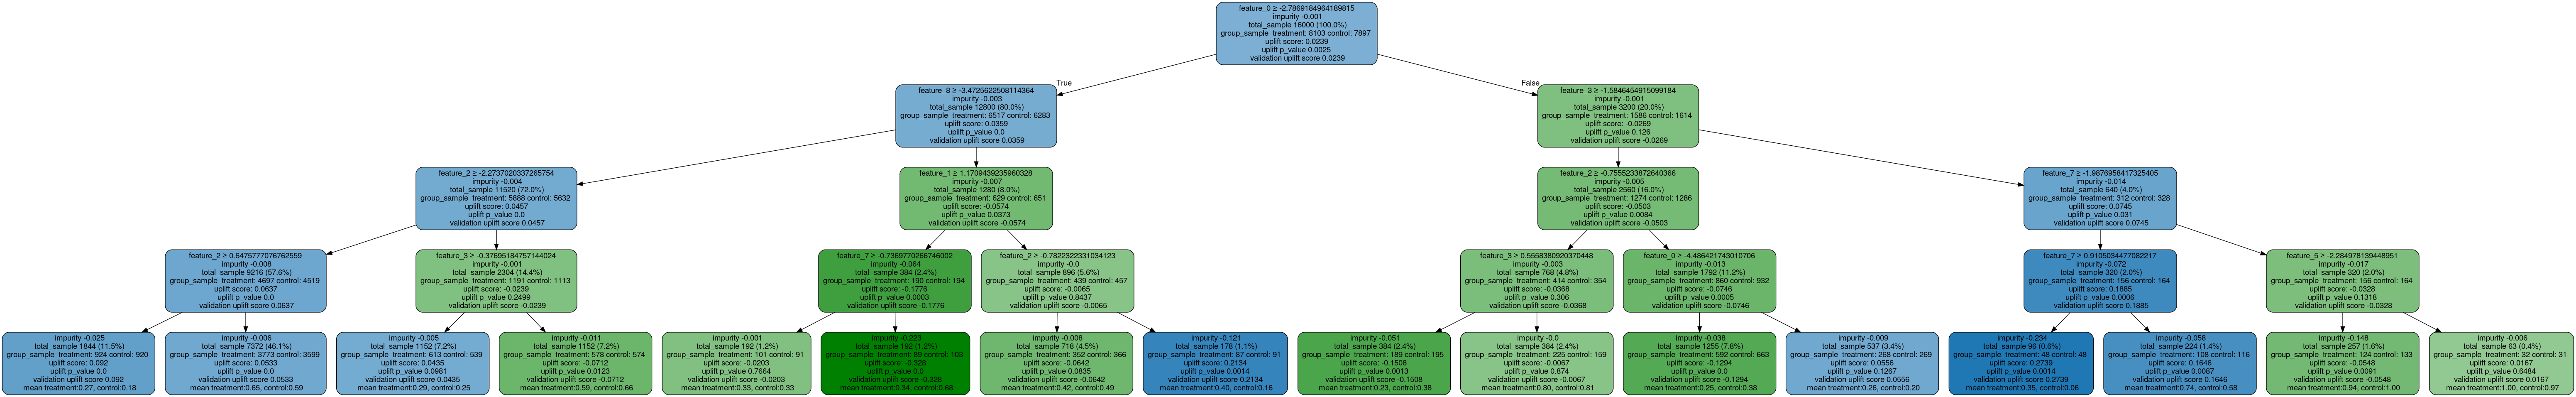

In [79]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

In [9]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[1].fitted_uplift_tree, feature_cols)
img = Image(graph.create_png())

In [10]:
#for i in range(ntree):
#    graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[i].fitted_uplift_tree, feature_cols)
#    with open("/home/mori/Documents/h2o/code/test/uplift/causal_tree/causal_tee_"+str(i)+".png", "wb") as fout:
#        fout.write(graph.create_png())

## H2O-3

In [254]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 23 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.817 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [255]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric="KL",
            distribution="bernoulli",
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.99,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf Model Build progress: |█████████████████████████████████████████| 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1624980973346_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,20.0,6413.0,19.0,19.0,19.0,20.0,22.0,21.0




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 0.0

Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc
0,,2021-06-29 17:37:40,0.141 sec,0.0,NaN
1,,2021-06-29 17:41:22,3 min 42.438 sec,10.0,0.0



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,feature_6,445.258545,1.000000,0.342411
1,feature_0,376.511139,0.845601,0.289543
2,feature_2,224.485794,0.504170,0.172633
3,feature_7,91.336563,0.205132,0.070239
4,feature_9,55.662270,0.125011,0.042805
5,feature_3,52.161217,0.117148,0.040113
6,feature_5,15.038450,0.033775,0.011565
7,feature_1,14.343245,0.032213,0.011030
8,feature_4,12.918944,0.029014,0.009935
9,feature_8,12.645397,0.028400,0.009725


In [256]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)
preds_h2o

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf prediction progress: |██████████████████████████████████████████| 100%


uplift_predict,p_y1_ct1,p_y1_ct0
-0.0139416,0.519868,0.533809
-0.0139416,0.519868,0.533809
-0.0276157,0.473322,0.500938
-0.0139416,0.519868,0.533809
-0.0139416,0.519868,0.533809
-0.0254075,0.543699,0.569107
-0.0139416,0.519868,0.533809
0.382459,0.826903,0.444444
-0.0393553,0.441392,0.480748
-0.0139416,0.519868,0.533809


In [257]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.22293801121413706,-0.16388500000000006,0.0008739085309505956,,0.0
mean,-0.006289332877378935,0.11651107249999999,0.1511613786894383,,0.4825
maxs,0.38245865106582644,0.5079738,0.694093631353426,,1.0
sigma,0.07740706528476342,0.1131017429096444,0.10882771029451749,,0.5003194468259059
zeros,0,0,0,,207
missing,0,0,0,0,0
0,-0.013941618800163313,0.1892728,0.2032144188001633,treatment,0.0
1,-0.013941618800163313,0.1643558,0.1782974188001633,treatment,1.0
2,-0.027615726739168178,0.07075310000000007,0.09836882673916825,control,0.0


min: 0.000874 max: 0.694094 mean: 0.151161


In [258]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
3.4893888394180728
CauslML AUUC:
11.393185648869604
Random AUUC:
-2.420792145330266


In [259]:
perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))


H2O training metrics AUUC Gain: 3.571582724421399


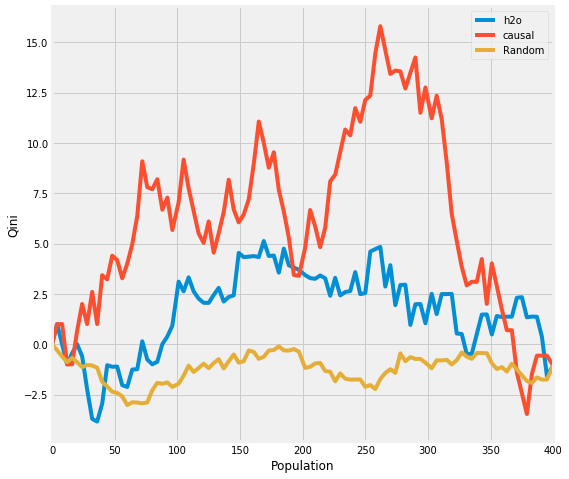

In [260]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

3851
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,

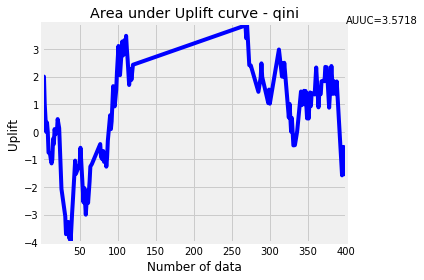

In [253]:
n, uplift = perf_h2o.plot_auuc(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="qini")

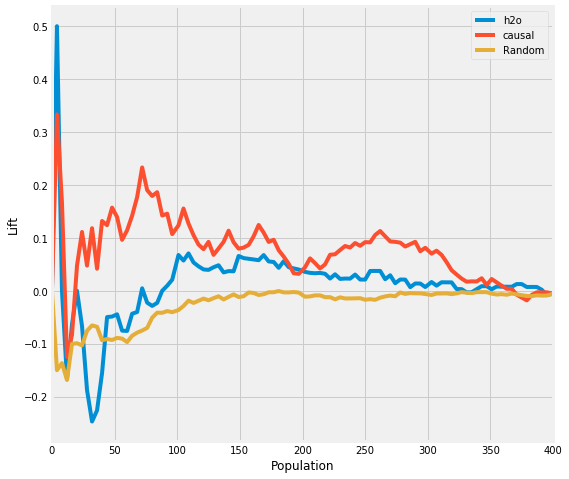

In [261]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)


[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 5

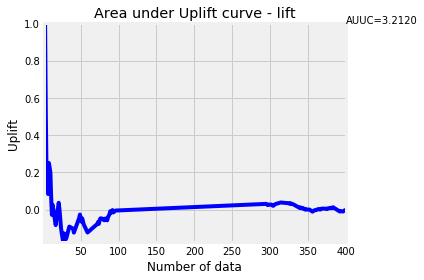

In [149]:
n, uplift = perf_h2o.plot_auuc(metric="lift", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="lift")

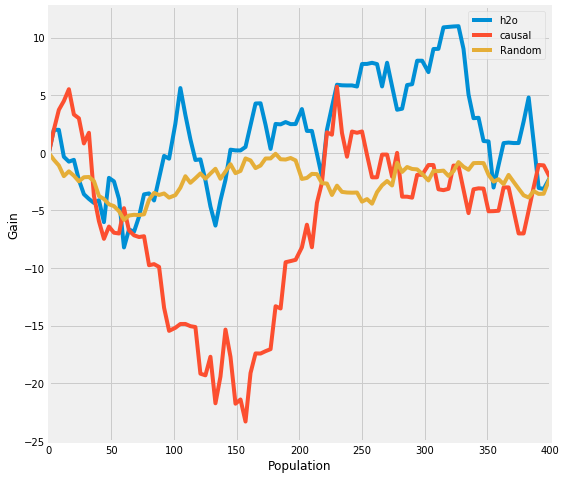

In [150]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 5

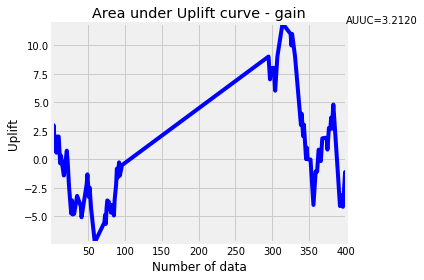

In [151]:
n, uplift = perf_h2o.plot_auuc(metric="gain", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="gain")